In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



FileNotFoundError: [Errno 2] No such file or directory: 'D:\\NIH Xray Dataset\\Data_Entry_2017.csv'

In [2]:
# === STEP 2: Load and Filter Dataset (Unbalanced) ===
#DATA_DIR = r'D:\NIH Xray Dataset'
DATA_DIR = r'D:\xray_files\xray'
CSV_PATH = os.path.join(DATA_DIR, 'Data_Entry_2017.csv')
IMG_SIZE = 224
target_classes = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Pneumonia', 'No Finding']

df = pd.read_csv(CSV_PATH)
df['Finding Labels'] = df['Finding Labels'].str.strip()
df_filtered = df[df['Finding Labels'].isin(target_classes)].copy()

# Optional: Display class distribution before balancing
print("Class distribution before balancing:")
print(df_filtered['Finding Labels'].value_counts())

# Encode labels
df_filtered['label_code'] = pd.Categorical(df_filtered['Finding Labels'], categories=target_classes).codes

# === STEP 4: Apply Weighted Sampling ===
sample_weights = df_filtered['Finding Labels'].map(
    lambda x: len(x.split('|')) if len(x) > 0 else 0
).values + 4e-2

sample_weights /= sample_weights.sum()

df_sampled = df_filtered.sample(
    20000, 
    weights=sample_weights, 
    replace=True,  # allow oversampling
    random_state=42
)

print("\nClass distribution AFTER weighted sampling:")
print(df_sampled['Finding Labels'].value_counts())

# === STEP 3: Image Path Helper ===
def find_image_path(file_name, base_dir):
    for i in range(1, 13):
        sub_dir = os.path.join(base_dir, f'images_{i:03d}', 'images')
        file_path = os.path.join(sub_dir, file_name)
        if os.path.exists(file_path):
            return file_path
    return None

Class distribution before balancing:
Finding Labels
No Finding      60361
Atelectasis      4215
Effusion         3955
Cardiomegaly     1093
Pneumonia         322
Name: count, dtype: int64

Class distribution AFTER weighted sampling:
Finding Labels
No Finding      17200
Atelectasis      1266
Effusion         1138
Cardiomegaly      296
Pneumonia         100
Name: count, dtype: int64


In [12]:
def preprocess_image_clahe(file_name):
    file_path = find_image_path(file_name, DATA_DIR)
    if not file_path:
        print(f"Missing: {file_name}")
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))
    
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # Step 1: Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Step 2: CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Step 3: Sharpen (optional)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)

    # Step 4: Normalize
    img = img / 255.0

    # Step 5: Convert to 3 channels
    img = np.stack([img]*3, axis=-1)

    return img

In [13]:
# === Apply CLAHE enhancement to all sampled images ===
enhanced_images = []
enhanced_labels = []

for idx, row in df_sampled.iterrows():
    img_array = preprocess_image_clahe(row['Image Index'])  # enhance the image
    enhanced_images.append(img_array)
    enhanced_labels.append(row['label_code'])  # store numeric labels for training

enhanced_images = np.array(enhanced_images, dtype=np.float32)
enhanced_labels = np.array(enhanced_labels, dtype=np.int64)

print(f"Enhanced dataset shape: {enhanced_images.shape}")
print(f"Labels shape: {enhanced_labels.shape}")

# OPTIONAL: save to disk as preprocessed dataset
np.save("x_ray_enhanced/xray_images_clahe.npy", enhanced_images)
np.save("x_ray_labels/xray_labels.npy", enhanced_labels)

KeyboardInterrupt: 

In [5]:
#PAUL VERSION
# === STEP 5: Train-Test Split ===
from sklearn.model_selection import train_test_split

df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

df_train, df_test = train_test_split(
    df_sampled,
    test_size=0.2,
    random_state=42,
    stratify=df_sampled['Finding Labels']
)

# === STEP 6: Create Generators ===
BATCH_SIZE = 16

train_gen = ChestXRayGenerator(
    df_train, DATA_DIR, target_classes, IMG_SIZE, BATCH_SIZE, shuffle=True
)

test_gen = ChestXRayGenerator(
    df_test, DATA_DIR, target_classes, IMG_SIZE, BATCH_SIZE, shuffle=False
)

# Debug: Print class distribution
print("Train class distribution:")
print(df_train['Finding Labels'].value_counts())
print(f"\nTotal training batches: {len(train_gen)}, Batch size: {BATCH_SIZE}")

Train class distribution:
Finding Labels
No Finding      13760
Atelectasis      1013
Effusion          910
Cardiomegaly      237
Pneumonia          80
Name: count, dtype: int64

Total training batches: 1000, Batch size: 16


In [6]:
# Compute class weights from training labels
from sklearn.utils.class_weight import compute_class_weight

y_train_labels = df_train['label_code'].values
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(3.15893385982231), 1: np.float64(13.50210970464135), 2: np.float64(3.5164835164835164), 3: np.float64(40.0), 4: np.float64(0.23255813953488372)}


In [7]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')
base_model.trainable = False  # Freeze backbone

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(target_classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\Paul Josef\AppData\Local\Temp\ipykernel_1228\1249418432.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True),
    ModelCheckpoint('best_chest_xray_model.keras', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

C:\Users\Paul Josef\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


C:\Users\Paul Josef\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


   9/1000 ━━━━━━━━━━━━━━━━━━━━ 21:36 1s/step - accuracy: 0.0365 - loss: 1.7804

KeyboardInterrupt: 

In [1]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Running on device: ", tf.test.gpu_device_name() if tf.test.gpu_device_name() else "CPU")



GPU Available:  []
Running on device:  CPU


11/11 [==============================] - 4s 331ms/step - loss: 1.6282 - accuracy: 0.3354
[RESULT] Test Accuracy: 0.3354, Loss: 1.6282
[RESULT] Test Accuracy: 0.3354, Loss: 1.6282
1/1 [==============================] - 0s 42ms/step


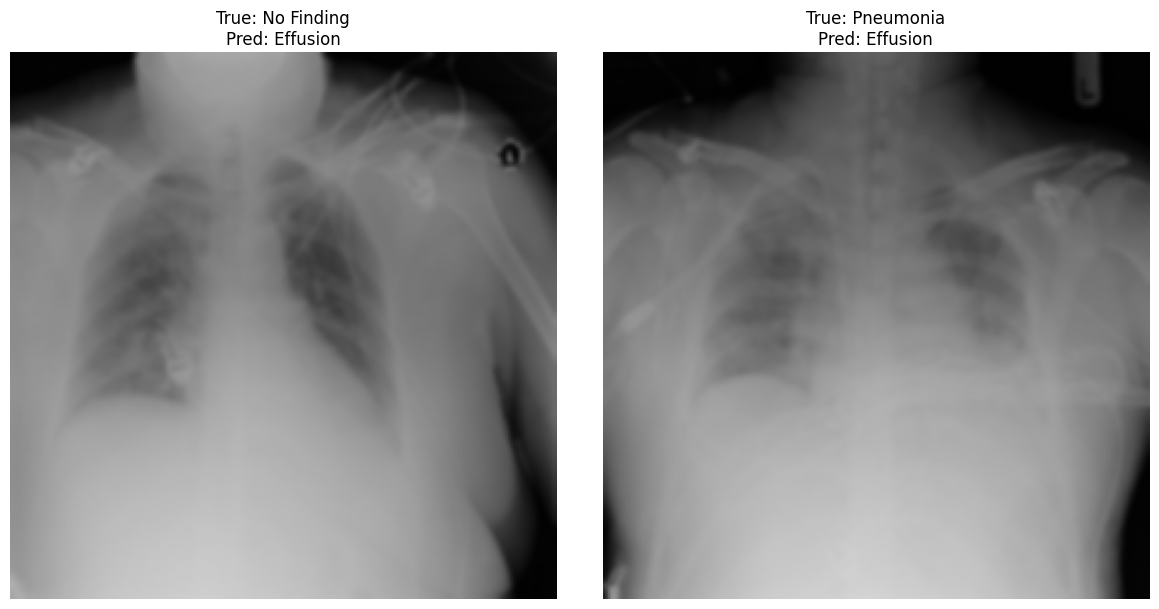

In [ ]:
# === STEP 9: Evaluate Final Test Accuracy ===
loss, acc = model.evaluate(val_aug.flow(X_test, y_test), verbose=1)
print(f"[RESULT] Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")


# test on actual test set, show via matplotlib 2 images
def show_test_images(X, y, model, num_images=2):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = np.argmax(y[idx])
        pred_label = np.argmax(model.predict(np.expand_dims(img, axis=0)))
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {target_classes[true_label]}\nPred: {target_classes[pred_label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_test_images(X_test, y_test, model, num_images=2)

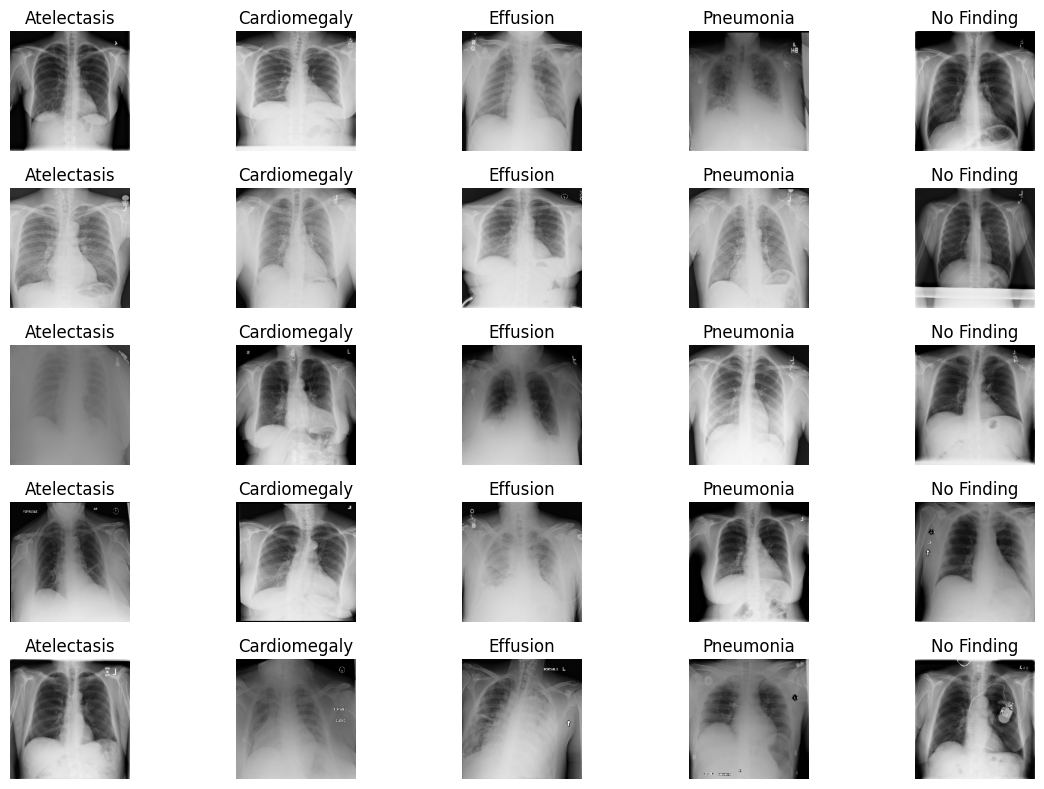

In [ ]:
# show 5 images of each type in the test set
def show_test_samples(df, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i, cls in enumerate(target_classes):
        sample = df[df['Finding Labels'] == cls].sample(num_samples)
        for j, (_, row) in enumerate(sample.iterrows()):
            img_path = find_image_path(row['Image Index'], DATA_DIR)
            if img_path:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                plt.subplot(num_samples, len(target_classes), j * len(target_classes) + i + 1)
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.title(cls)
                plt.axis('off')
    plt.tight_layout()
    plt.show()

show_test_samples(df_balanced, num_samples=5)


In [4]:
# test if tensorflow working
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))
a = torch.rand(5000, 5000).cuda()
b = torch.mm(a, a)
print("Done matrix multiplication on GPU.")

CUDA available: True
GPU Name: NVIDIA GeForce GTX 1650 with Max-Q Design
Done matrix multiplication on GPU.


In [ ]:
### Train/Validation/Test Split
from sklearn.model_selection import train_test_split

# 80% train, 10% val, 10% test
train_df, test_df = train_test_split(df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['Finding Labels'])

train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['Finding Labels'], random_state=42)

### DEBUG: Display the splits and percentages
print("\nDataset splits:")
print(f"Train samples: {len(train_df)}, {len(train_df)/len(df_balanced)*100:.2f}%")
print(f"Validation samples: {len(val_df)}, {len(val_df)/len(df_balanced)*100:.2f}%")
print(f"Test samples: {len(test_df)}, {len(test_df)/len(df_balanced)*100:.2f}%")
# Display pixel dimensions (width x height) for a few images in the dataset
print("\nSample image dimensions (pixels):")
for idx, row in df_balanced.head(5).iterrows():
    width = row['OriginalImage[Width']
    height = row['Height]']
    print(f"{row['Image Index']}: {width}x{height}")

### DEBUG: Display class distribution in each split
print("\nClass distribution in splits:")
print("Train:\n", train_df['Finding Labels'].value_counts())
print("Validation:\n", val_df['Finding Labels'].value_counts())
print("Test:\n", test_df['Finding Labels'].value_counts())



Dataset splits:
Train samples: 1159, 71.99%
Validation samples: 129, 8.01%
Test samples: 322, 20.00%

Sample image dimensions (pixels):
00015468_000.png: 2992x2991
00008051_006.png: 2500x2048
00028628_006.png: 1767x2021
00000618_000.png: 2596x2364
00020773_003.png: 2578x2991

Class distribution in splits:
Train:
 Finding Labels
Pneumonia       232
No Finding      232
Effusion        232
Cardiomegaly    232
Atelectasis     231
Name: count, dtype: int64
Validation:
 Finding Labels
Cardiomegaly    26
Pneumonia       26
Effusion        26
Atelectasis     26
No Finding      25
Name: count, dtype: int64
Test:
 Finding Labels
Atelectasis     65
No Finding      65
Cardiomegaly    64
Effusion        64
Pneumonia       64
Name: count, dtype: int64
